In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm, ensemble, linear_model
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix,matthews_corrcoef
from sklearn.decomposition import PCA

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import joblib
import warnings

In [3]:
# Carga de datos
DATA_PATH = '/data/sespinoza/objetivo3/1-experimento/'
all_cancers = pd.read_csv( DATA_PATH + 'liver-final.csv', header=0, sep=',', encoding='utf-8')
data_peru = pd.read_csv(DATA_PATH + 'data_peru-final.csv', header=0, sep=',', encoding='utf-8')

In [4]:
print(all_cancers.shape)
print(data_peru.shape)

(491, 19966)
(69, 19966)


In [5]:
#concatena los dos datasets
data_proba = pd.concat([all_cancers, data_peru], axis=0)
print(data_proba.shape)

(560, 19966)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, nb_input):
        super(MLP, self).__init__()
        
        # Definimos las capas
        self.gaussian_noise_std = 0.1  # Ajusta el valor de ruido gaussiano
        self.fc1 = nn.Linear(nb_input, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 3)
        
    def forward(self, x):
        # Agregar ruido gaussiano manualmente
        if self.training:  # Solo agrega ruido en modo de entrenamiento
            noise = torch.randn_like(x) * self.gaussian_noise_std
            x = x + noise
            
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.softmax(self.output_layer(x), dim=1)  # Usamos softmax en la capa de salida
        return x

In [7]:
classifiers = {
    'SVM Linear': {
        'model': svm.SVC(kernel='linear'),
        'params': {'svm_linear__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    },
    'SVM RBF': {
        'model': svm.SVC(kernel='rbf'),
        'params': {
            'svm_rbf__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'svm_rbf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto']
        }
    },
    'Logistic Regression': {
        'model': linear_model.LogisticRegression(max_iter=1000, solver='liblinear'),
        'params': {
            'logistic_regression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logistic_regression__penalty': ['l1', 'l2']
        }
    },
    'Random Forest': {
        'model': ensemble.RandomForestClassifier(random_state=42),
        'params': {
            'random_forest__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'random_forest__max_depth': [None, 5, 10, 20],
            'random_forest__min_samples_split': [2, 5, 10]
        }
    },
    'Boosting': {
        'model': ensemble.AdaBoostClassifier(random_state=42),
        'params': {
            'boosting__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'boosting__learning_rate': [0.01, 0.1, 1]
        }
    }
}

In [8]:
import joblib

# Ruta del archivo .pkl
file_path = 'best_params_reconstructed.pkl'

# Cargar el archivo .pkl
best_params = joblib.load(file_path)

In [9]:
# Separar características y etiquetas del conjunto de entrenamiento
X = all_cancers.drop('labels', axis=1)
y = all_cancers['labels']

In [10]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [11]:
# **Entrenamiento de Modelos Finales**
from sklearn.decomposition import PCA

# Realiza la selección de características en todo el conjunto de entrenamiento
MI = mutual_info_classif(X_scaled, y)
n_features_mi = 5000
selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]
X_mi = X_scaled.iloc[:, selected_scores_indices]

estimator = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
n_features_rfe = 100
rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe.fit(X_mi, y)
X_selected = rfe.transform(X_mi)
X_final=X_selected

In [12]:
# Entrenar los modelos finales
# **Análisis de Resultados**
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef,roc_auc_score
from collections import Counter
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
final_models = {}
for name, clf_info in classifiers.items():
    model = clf_info['model']
    # Obtener los mejores hiperparámetros
    param_counts = Counter(tuple(sorted(params.items())) for params in best_params[name])
    most_common_params = dict(param_counts.most_common(1)[0][0])

    # Crear pipeline con el modelo
    pipeline = Pipeline([
        (name.lower().replace(' ', '_'), model)
    ])

    # Establecer los hiperparámetros utilizando los nombres completos
    pipeline.set_params(**most_common_params)
    pipeline.fit(X_final, y)
    final_models[name] = pipeline
    # Guardar el modelo
    joblib.dump(pipeline, f'final_{name.lower().replace(" ", "_")}_model.pkl')

# Entrenar el modelo final de la Red Neuronal
# Preparar los datos para PyTorch
X_tensor = torch.tensor(X_final, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Instanciar el modelo MLP
mlp = MLP(nb_input=X_final.shape[1])  # Asegúrate de que ya tienes la definición de MLP en PyTorch
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Entrenar el modelo final de la Red Neuronal
epochs = 100
mlp.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = mlp(inputs)  # Hacer una pasada de forward
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar los pesos

        running_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Guardar el modelo entrenado
torch.save(mlp.state_dict(), 'final_neural_network_model.pth')
final_models['Neural Network'] = mlp

/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Epoch [10/100], Loss: 0.9548
Epoch [20/100], Loss: 0.7755
Epoch [30/100], Loss: 0.6957
Epoch [40/100], Loss: 0.5915
Epoch [50/100], Loss: 0.5597
Epoch [60/100], Loss: 0.5562
Epoch [70/100], Loss: 0.5544
Epoch [80/100], Loss: 0.5536
Epoch [90/100], Loss: 0.5530
Epoch [100/100], Loss: 0.5526


In [13]:
def predict_pytorch(model, data):
    model.eval()  # Cambiar a modo evaluación
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        inputs = torch.tensor(data, dtype=torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con la mayor probabilidad
    return predicted.numpy()

In [14]:
data_peru

,LOC101928626,LINC01128,LOC284600,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,LINC01342,TTLL10,...,CPT1B,CHKB,MAFIP,MSH5,LOC389831,FAM230C,LOC389834,LOC283788,FRG1CP,labels
0,5.405768,7.105810,6.407605,6.751036,6.423195,6.509502,6.651562,7.064638,5.995642,6.327105,...,6.501750,6.907690,8.422326,6.115378,6.888611,5.007248,8.925795,8.068007,6.872607,0
1,4.159188,6.299034,6.178953,6.465379,6.308839,6.390281,6.867204,6.849003,5.681353,6.067419,...,6.614204,7.139718,7.682306,7.396560,8.341874,4.919640,8.281252,8.078099,6.560089,0
2,4.811373,6.420369,6.110383,6.702332,6.452215,6.426228,7.000279,7.037242,5.676338,6.306445,...,6.688823,7.212832,7.194405,7.307553,7.984998,4.998576,7.792717,7.839151,6.482906,0
3,5.120837,6.470795,6.181780,6.514313,6.229662,6.400035,6.639504,7.451014,5.473437,6.110803,...,6.650639,7.291541,8.605102,7.140464,8.833814,4.915654,8.994024,7.948627,6.532978,0
4,4.678503,7.015001,6.299136,6.690043,6.372549,6.594241,6.670578,7.020186,5.861442,6.309986,...,6.602375,7.211246,8.250206,6.661626,7.212454,4.834216,8.829757,8.220692,7.079568,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,4.300831,6.799858,6.132306,6.694394,6.234502,6.390698,6.624664,6.719779,5.541144,6.132209,...,6.350879,7.008382,7.731767,6.853608,7.249560,4.971040,8.180356,7.914202,6.712507,1
65,4.933752,7.209855,6.134703,6.799384,6.372639,6.534240,6.775209,6.809262,5.995258,6.227656,...,6.566923,7.070441,7.626210,6.467202,7.472178,4.965690,8.102796,7.944149,6.956125,1
66,4.809190,6.608746,6.249217,6.789390,6.510175,6.566593,6.925290,6.907346,5.682360,6.334061,...,6.426555,7.026294,8.011013,6.447739,7.064877,4.960135,8.575175,7.802760,6.692546,1
67,4.590937,7.321604,6.349540,6.746459,6.456240,6.543193,6.818618,6.847280,5.798905,6.306778,...,6.502476,7.075977,7.967216,6.311019,6.067004,4.752972,8.623297,7.743439,6.548646,1


In [15]:
all_cancers

,LOC101928626,LINC01128,LOC284600,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,LINC01342,TTLL10,...,CPT1B,CHKB,MAFIP,MSH5,LOC389831,FAM230C,LOC389834,LOC283788,FRG1CP,labels
0,3.806209,8.076479,5.738328,6.187291,5.372911,6.953914,8.042587,5.818991,5.585166,4.168620,...,6.697681,8.635710,6.148663,7.532169,9.440063,3.248441,7.532371,3.144306,8.487132,0
1,3.881654,8.215927,5.424668,6.254732,5.085696,6.387979,8.468383,5.630184,5.241042,4.290088,...,8.204544,8.705704,6.457422,7.231677,9.163460,3.292112,7.780304,3.097928,8.795503,0
2,3.541903,7.624953,5.729815,7.106816,5.210060,6.754647,8.264215,6.140819,5.753744,4.545636,...,8.394142,8.746424,5.993691,6.893785,9.502198,3.392558,6.753100,2.916421,8.250897,0
3,3.632725,7.565191,5.686019,7.252060,5.740385,6.920475,8.577148,6.510498,5.959703,4.582159,...,7.908254,8.709072,6.098331,6.822250,9.430469,3.455842,6.709632,3.032940,8.353957,0
4,3.447869,8.641499,6.068630,6.775690,5.749888,7.684341,10.888259,6.386816,6.217690,4.528610,...,7.040256,8.692293,7.661688,5.710771,9.548107,3.322931,6.957208,3.153447,8.096021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,3.767617,8.280992,5.169916,6.436522,5.480042,6.750323,11.290163,5.774120,5.645721,4.421364,...,5.903785,8.311866,8.066919,5.584676,9.161591,3.243018,6.387265,2.924262,8.768290,1
487,3.727972,8.334519,5.358716,6.460135,5.621654,6.466298,9.277809,6.043487,5.847036,4.467405,...,5.888379,8.204076,7.370456,4.386651,9.480064,3.904211,5.337200,3.325673,8.707134,1
488,3.624031,7.741809,5.245615,6.632979,5.984046,5.723635,8.402543,6.008598,5.701103,4.966423,...,5.775428,7.703548,8.474883,5.211689,8.512439,3.442579,7.845785,3.005835,9.044046,0
489,3.846306,7.837816,5.362450,6.333071,6.351790,5.911638,8.598721,5.940016,5.608722,5.025837,...,6.056186,7.844428,8.335279,5.660493,9.086552,3.061639,7.740909,3.069799,9.011331,0


Evaluación del modelo SVM Linear en el conjunto reservado:
Modelo: SVM Linear, Accuracy: 0.8115942028985508, F1 Score: 0.8095294818344252, MCC: 0.6819943394704735
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        39
           1       0.70      1.00      0.82        30

    accuracy                           0.81        69
   macro avg       0.85      0.83      0.81        69
weighted avg       0.87      0.81      0.81        69

Matriz de confusión para SVM Linear:
[[26 13]
 [ 0 30]]


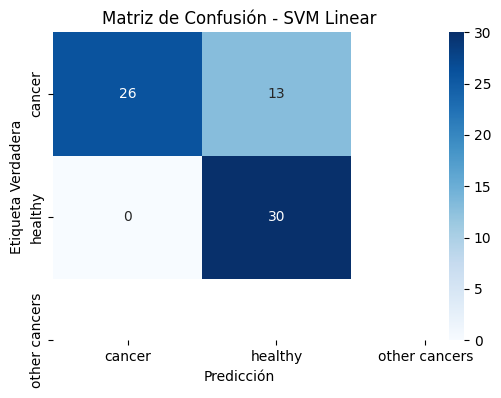

Evaluación del modelo SVM RBF en el conjunto reservado:
Modelo: SVM RBF, Accuracy: 0.855072463768116, F1 Score: 0.8547679941541834, MCC: 0.7467879938056768
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        39
           1       0.75      1.00      0.86        30

    accuracy                           0.86        69
   macro avg       0.88      0.87      0.86        69
weighted avg       0.89      0.86      0.85        69

Matriz de confusión para SVM RBF:
[[29 10]
 [ 0 30]]


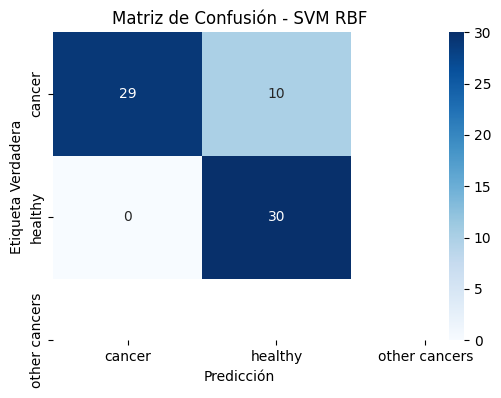

Evaluación del modelo Logistic Regression en el conjunto reservado:
Modelo: Logistic Regression, Accuracy: 0.7246376811594203, F1 Score: 0.7134128709084634, MCC: 0.5603318146805258
              precision    recall  f1-score   support

           0       1.00      0.51      0.68        39
           1       0.61      1.00      0.76        30

    accuracy                           0.72        69
   macro avg       0.81      0.76      0.72        69
weighted avg       0.83      0.72      0.71        69

Matriz de confusión para Logistic Regression:
[[20 19]
 [ 0 30]]


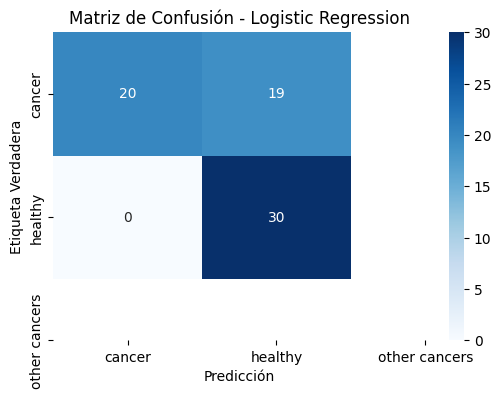

Evaluación del modelo Random Forest en el conjunto reservado:
Modelo: Random Forest, Accuracy: 0.5507246376811594, F1 Score: 0.47908428296957434, MCC: 0.31762040840214206
              precision    recall  f1-score   support

           0       1.00      0.21      0.34        39
           1       0.49      1.00      0.66        30

    accuracy                           0.55        69
   macro avg       0.75      0.60      0.50        69
weighted avg       0.78      0.55      0.48        69

Matriz de confusión para Random Forest:
[[ 8 31]
 [ 0 30]]


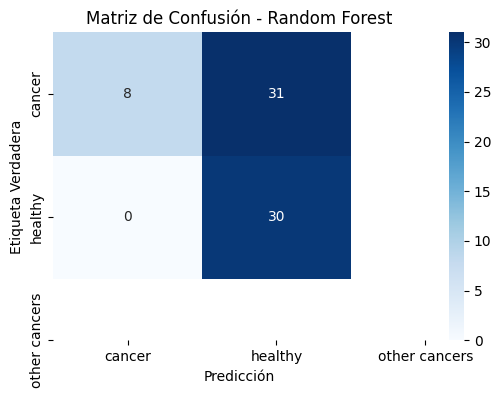

Evaluación del modelo Boosting en el conjunto reservado:
Modelo: Boosting, Accuracy: 0.5507246376811594, F1 Score: 0.47908428296957434, MCC: 0.31762040840214206
              precision    recall  f1-score   support

           0       1.00      0.21      0.34        39
           1       0.49      1.00      0.66        30

    accuracy                           0.55        69
   macro avg       0.75      0.60      0.50        69
weighted avg       0.78      0.55      0.48        69

Matriz de confusión para Boosting:
[[ 8 31]
 [ 0 30]]


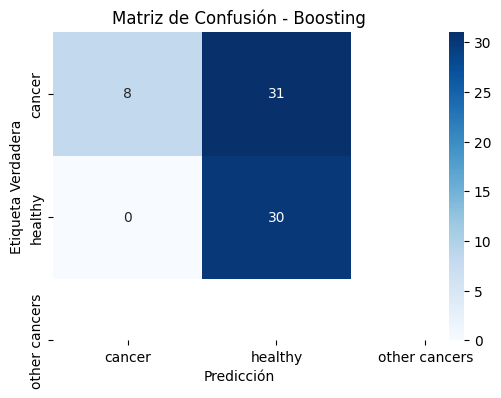

Evaluación del modelo Neural Network en el conjunto reservado:
Modelo: Neural Network, Accuracy: 0.7971014492753623, F1 Score: 0.794102526439483, MCC: 0.6611073566849314
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        39
           1       0.68      1.00      0.81        30

    accuracy                           0.80        69
   macro avg       0.84      0.82      0.80        69
weighted avg       0.86      0.80      0.79        69

Matriz de confusión para Neural Network:
[[25 14]
 [ 0 30]]


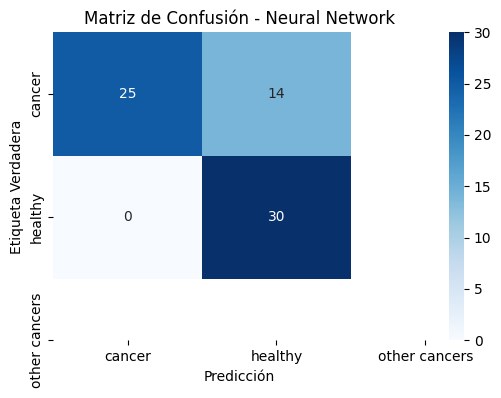

Modelo: SVM Linear, Accuracy: 0.8115942028985508, F1 Score: 0.8095294818344252, MCC: 0.6819943394704735
Modelo: SVM RBF, Accuracy: 0.855072463768116, F1 Score: 0.8547679941541834, MCC: 0.7467879938056768
Modelo: Logistic Regression, Accuracy: 0.7246376811594203, F1 Score: 0.7134128709084634, MCC: 0.5603318146805258
Modelo: Random Forest, Accuracy: 0.5507246376811594, F1 Score: 0.47908428296957434, MCC: 0.31762040840214206
Modelo: Boosting, Accuracy: 0.5507246376811594, F1 Score: 0.47908428296957434, MCC: 0.31762040840214206
Modelo: Neural Network, Accuracy: 0.7971014492753623, F1 Score: 0.794102526439483, MCC: 0.6611073566849314


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# **Evaluación en el Conjunto Reservado**

# Preprocesar el conjunto reservado
#X_reserved = microarray_data_common.drop('labels', axis=1)
#y_reserved = microarray_data_common['labels']
#y_reserved_encoded = label_encoder.transform(y_reserved)

X_reserved = data_peru.drop('labels', axis=1)
y_reserved_encoded = data_peru['labels']
# Escalar las características
X_reserved_scaled = min_max_scaler.transform(X_reserved)
X_reserved_scaled = pd.DataFrame(X_reserved_scaled, columns=X_reserved.columns)

# Selección de características
X_reserved_mi = X_reserved_scaled.iloc[:, selected_scores_indices]
X_reserved_final = rfe.transform(X_reserved_mi)
#X_reserved_final = selection.transform(X_reserved_selected)

#X_reserved_final = pca.transform(X_reserved_final_1)

# Evaluar los modelos
for name, model in final_models.items():
    print(f"Evaluación del modelo {name} en el conjunto reservado:")
    if name == 'Neural Network':
        y_pred_reserved = predict_pytorch(model, X_reserved_final)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")
    print(classification_report(y_reserved_encoded, y_pred_reserved))

    # Calcular la matriz de confusión
    cm_reserved = confusion_matrix(y_reserved_encoded, y_pred_reserved)

    # Mostrar la matriz de confusión
    print(f"Matriz de confusión para {name}:")
    print(cm_reserved)
    custom_labels = ['cancer', 'healthy','other cancers']
    # Visualizar la matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_reserved, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred_reserved = predict_pytorch(model, X_reserved_final)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")